In [6]:
import uproot
import subprocess
import awkward as ak
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick
import pickle
import functools, operator

In [37]:
needed_branches = ["HLT_*", "TrigObj_*", "*GenVisTau_*"]
das_ZZ = {mass : f"/GluGluToXToZZTo2B2Tau_M-{mass}_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM"
    for mass in  [ 200,  250,  300, 350, 400, 450, 500, 550, # 210, 220, 230, 240, 260, 270, 280,  320,  360,
                600, 700, 800, 900, 1000, 1200,  1400, 1600, # 650 750 850
                1800,  2000,   2500,  3000, 3500, 4000, 4500, 5000]}
def getFilesForDas(dataset_das):
    res = subprocess.run(["dasgoclient", "-query", "file dataset=" + dataset_das], capture_output=True, text=True, check=True)
    return ["root://xrootd-cms.infn.it//" + path for path in res.stdout.split("\n") if len(path) > 1]
def getTrees(dataset_das, max_files=10):
    return [f+":Events" for f in getFilesForDas(dataset_das)][:max_files]
def genPairType_branch(ar):
    """ select etau, mutau, tautau at genlevel"""
    nGenVisTau = ak.num(ar.GenVisTau)
    tautau = nGenVisTau == 2

    mutau_genMuon_bool = (abs(ar.GenPart.pdgId) == 13) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    mutau_genMuon = ak.firsts(ar.GenPart[mutau_genMuon_bool]) # gen muon in GenPart collection
    mutau = (nGenVisTau == 1) & ak.any(mutau_genMuon_bool, axis=-1)
    
    etau_genMuon_bool = (abs(ar.GenPart.pdgId) == 11) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    etau_genMuon = ak.firsts(ar.GenPart[etau_genMuon_bool]) # gen muon in GenPart collection
    etau = (nGenVisTau == 1) & ak.any(etau_genMuon_bool, axis=-1)
    
    genPairType =  ak.where(mutau, 0, ak.where(etau, 1, ak.where(tautau, 2, -1)))
    genLepton = ak.where(mutau, mutau_genMuon, etau_genMuon) # for tautau will just put None
    return ak.with_field(ak.with_field(ar, genPairType, where="genPairType"), genLepton, "genLepton")
def loadFile(f):
    print(f)
    ar_1 = uproot.open(f).arrays(filter_name=needed_branches + ["GenPart_*"], how="zip")
    ar_2 = genPairType_branch(ar_1)
    return ak.to_packed(ar_2[[field for field in ar_2.fields if not field.startswith("GenPart")]])

In [36]:
ar_test = loadFile(getFilesForDas(das_ZZ[200])[0]+":Events")
ar_test

root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-200_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/676C93C0-FCFE-9640-9C80-0CE7CAF1E98D.root:Events


<Array [{...}, {...}, {...}, ..., {...}, {...}] type='3000 * {HLT_AK8PFJet3...'>

In [38]:
import concurrent.futures
def process_item(mass, das):
    ars_singleMass = [loadFile(f) for f in getTrees(das, max_files=5)]
    with open(f"ZZ_res_{mass}.pkl", "wb") as f:
        pickle.dump(ak.concatenate(ars_singleMass), f)

with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    for mass, das in das_ZZ.items():
        executor.submit(process_item, mass, das)


root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-250_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/C7E453B8-B149-924E-A3CB-D4E54BA7FE6B.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-450_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/387B0AB5-5B33-F646-97BE-87A33E27DAF5.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-700_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/056A70E0-837E-3F4D-B965-A411B9A1B87F.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-550_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/C9F5E4F2-35DF-2D47-8DC2-E7F7F2231295.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-

In [11]:
# ar_computing = {}
# for mass, das in das_ZZ.items():
#     print(mass)
#     ar_computing[mass] = [loadFile(f) for f in getTrees(das, max_files=5)]
# with open("ZZ_res.pkl", "wb") as f:
#     pickle.dump(ar_computing, f)
# ar_computing

200
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-200_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/676C93C0-FCFE-9640-9C80-0CE7CAF1E98D.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-200_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/7C3F04B5-0355-1D41-BB17-FB136362780F.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-200_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/CBC949BB-1CCD-0546-910A-FB21021C7CCB.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Tau_M-200_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2830000/48BF47B5-5E80-C54F-AEFB-2960B3B6A96F.root:Events
root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/GluGluToXToZZTo2B2Ta

{200: [<Array [{...}, {...}, {...}, ..., {...}, {...}] type='3000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='2000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='6000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='1000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='10000 * {HLT_AK8PFJet...'>],
 250: [<Array [{...}, {...}, {...}, ..., {...}, {...}] type='5000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='6000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='1000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='3000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='1000 * {HLT_AK8PFJet3...'>],
 300: [<Array [{...}, {...}, {...}, ..., {...}, {...}] type='1000 * {HLT_AK8PFJet3...'>,
  <Array [{...}, {...}, {...}, ..., {...}, {...}] type='100

In [39]:
# with open("ZZ_res.pkl", "rb") as f:
#     ar_computing = pickle.load(f)
# ars = {mass: ak.concatenate(ar_list) for mass, ar_list in ar_computing.items()}
# ars
ars = {}
for mass in das_ZZ:
    with open(f"ZZ_res_{mass}.pkl", "rb") as f:
        ars[mass] = pickle.load(f)
ars

{200: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='22000 * {HLT_AK8PFJet...'>,
 250: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='16000 * {HLT_AK8PFJet...'>,
 300: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='9000 * {HLT_AK8PFJet3...'>,
 350: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='12000 * {HLT_AK8PFJet...'>,
 400: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='113000 * {HLT_AK8PFJe...'>,
 450: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='15000 * {HLT_AK8PFJet...'>,
 500: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='17000 * {HLT_AK8PFJet...'>,
 550: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='11000 * {HLT_AK8PFJet...'>,
 600: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='34000 * {HLT_AK8PFJet...'>,
 700: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='13000 * {HLT_AK8PFJet...'>,
 800: <Array [{...}, {...}, {...}, ..., {...}, {...}] type='19000 * {HLT_AK8PFJet...'>,
 900: <Array [{...}, {...}, {...

In [40]:
HLT_interesting_paths = [
    "AK8PFHT800_TrimMass50",
    "AK8PFJet500",
    "AK8PFJet400_TrimMass30",
    "PFJet500",

    "MediumChargedIsoPFTau180HighPtRelaxedIso_Trk50_eta2p1",
    "MediumChargedIsoPFTau50_Trk30_eta2p1_1pr_MET110",

    "PFHT1050",
    "PFHT500_PFMET100_PFMHT100_IDTight",
    "PFMET120_PFMHT120_IDTight",
    "PFMETNoMu120_PFMHTNoMu120_IDTight"
]
# HLT_interesting_paths_btag = [
# "PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5",
# "QuadPFJet103_88_75_15_PFBTagDeepCSV_1p3_VBF2",
# "TripleJet110_35_35_Mjj650_PFMET110"
# ]


In [58]:
def eff(branch_num, filter_denom):
    try:
        return ak.count_nonzero(branch_num) / ak.count_nonzero(filter_denom)
    except:
        return ak.count_nonzero(branch_num) / len(filter_denom)
def tautau_channel(a):
    return ak.num(a.GenVisTau) == 2


def delta_phi(a, b):
    """Compute difference in angle given two angles a and b
    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi
def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)
    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)

def match_tau_gen(ar):
    """ Match tau to gen """
    gen_taus = ak.firsts(ar.GenVisTau)
    matched = (delta_r(gen_taus.eta, gen_taus.phi, ar.Tau.eta, ar.Tau.phi) < 0.4)
    return ak.firsts(ar.Tau[matched])

def tautau_acceptance(ar):
    return (ar.genPairType == 2) & ak.all(ar.GenVisTau.eta < 2.4, axis=-1)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

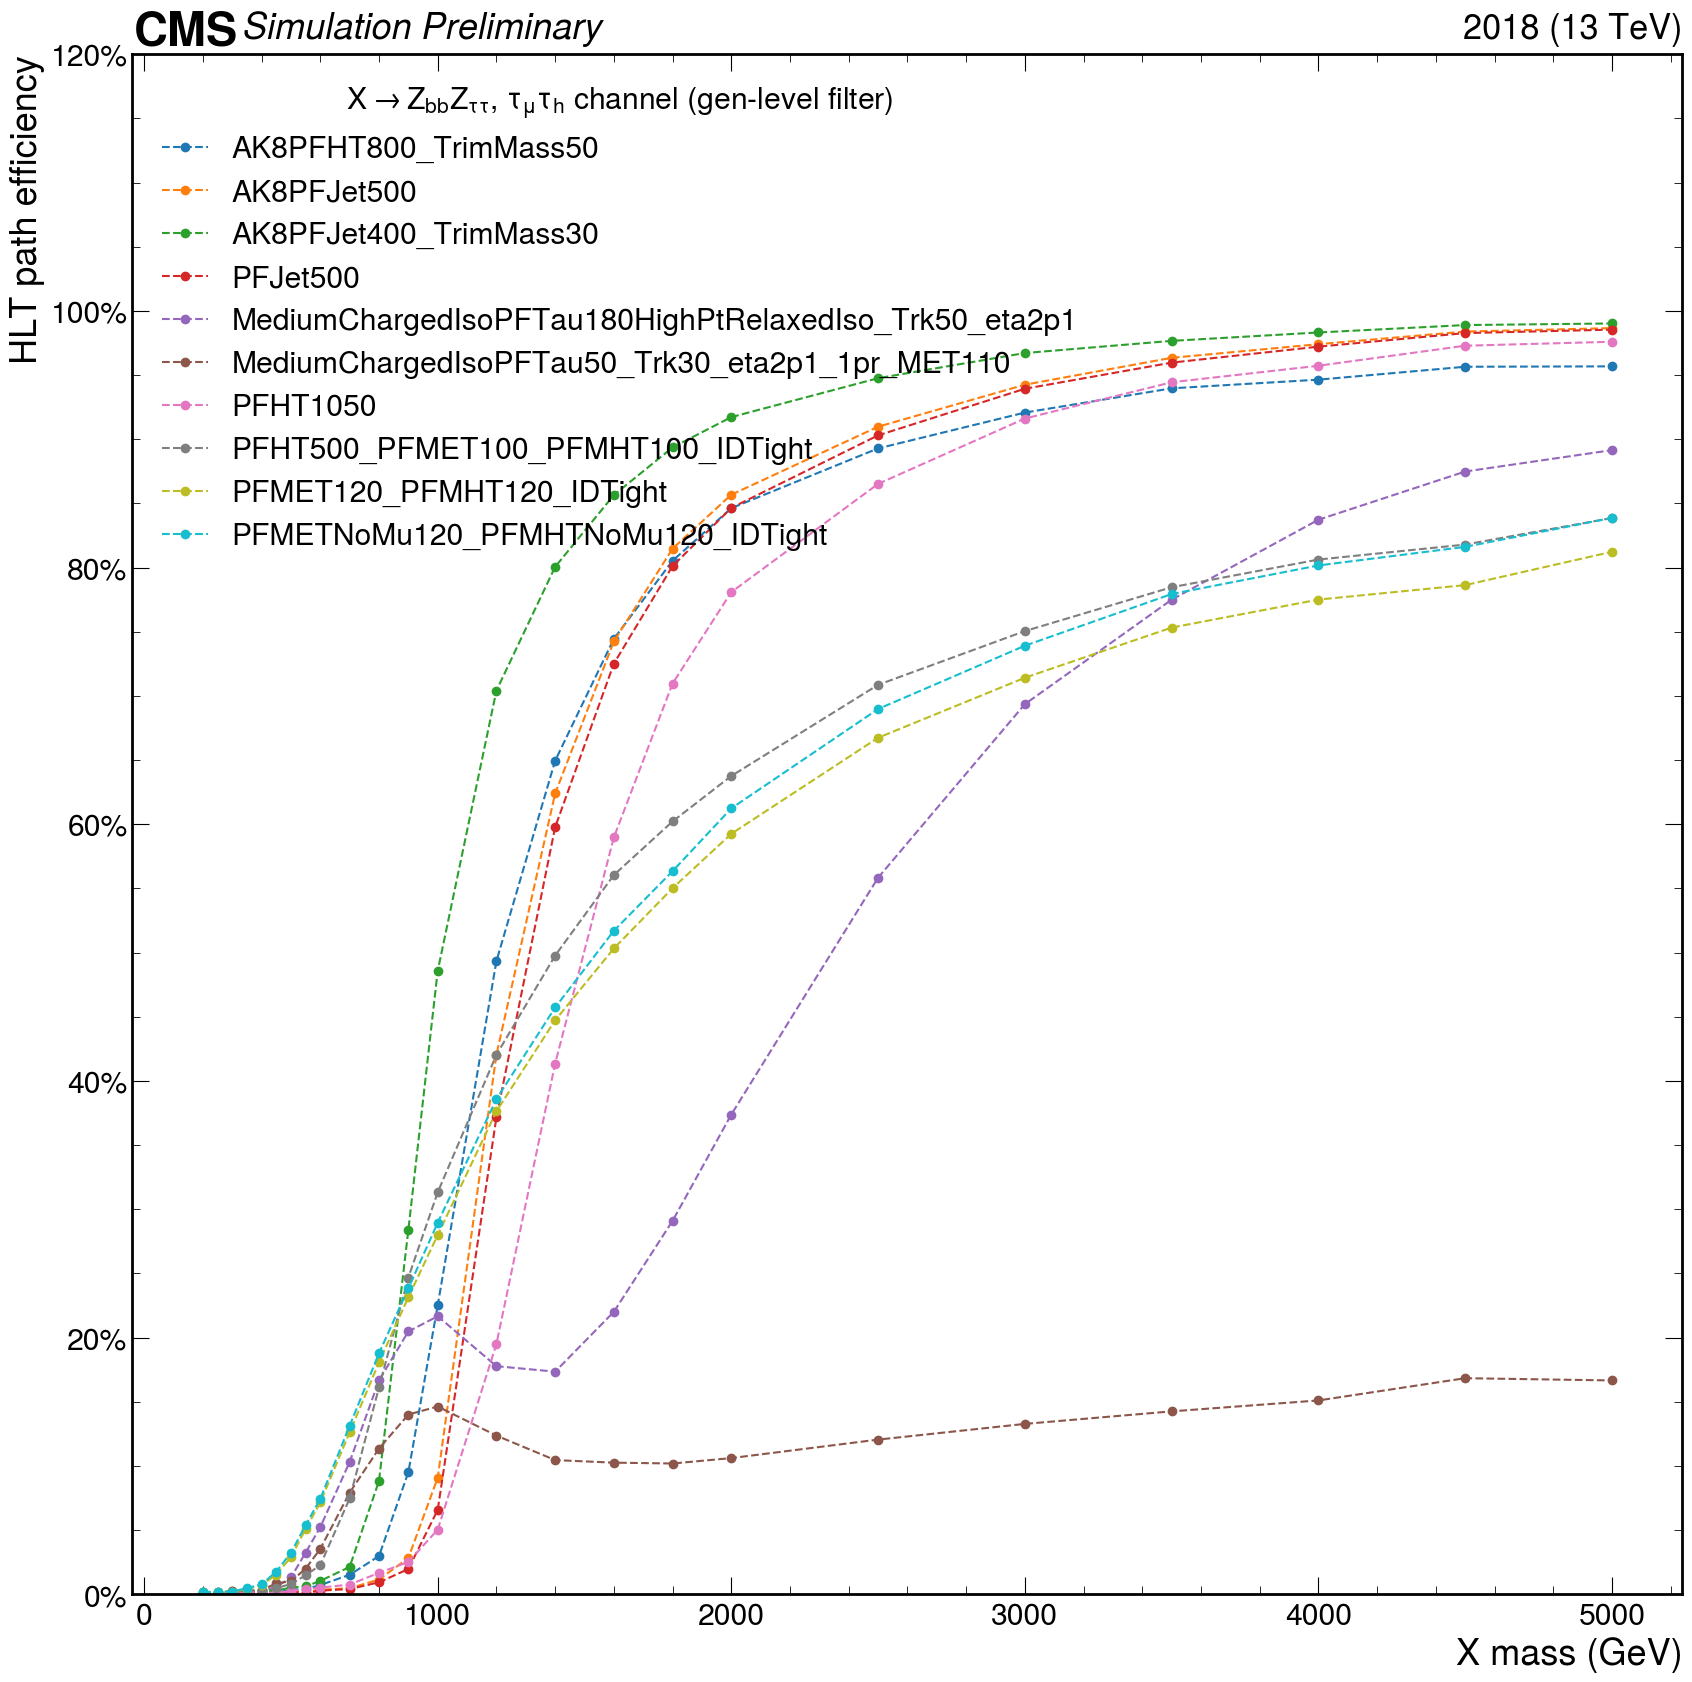

In [59]:
effs = defaultdict(dict)
for mass, ar_mass in ars.items():
    tautau_channel_filter = tautau_acceptance(ar_mass)
    cut = tautau_channel_filter

    for hlt_path in HLT_interesting_paths:
        effs[hlt_path][mass] = eff(ar_mass["HLT_"+hlt_path][tautau_channel_filter], tautau_channel_filter)

    # eff_singlemu_trigger_genmatched[mass] =ak.count_nonzero(singlemu_trigger_matchGen(ar[genMuTau], singlemu_trigger(ar[genMuTau]))) / ak.count_nonzero(genMuTau)

plt.figure(figsize=(20, 20))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("HLT path efficiency")
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)", loc="upper left")
hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

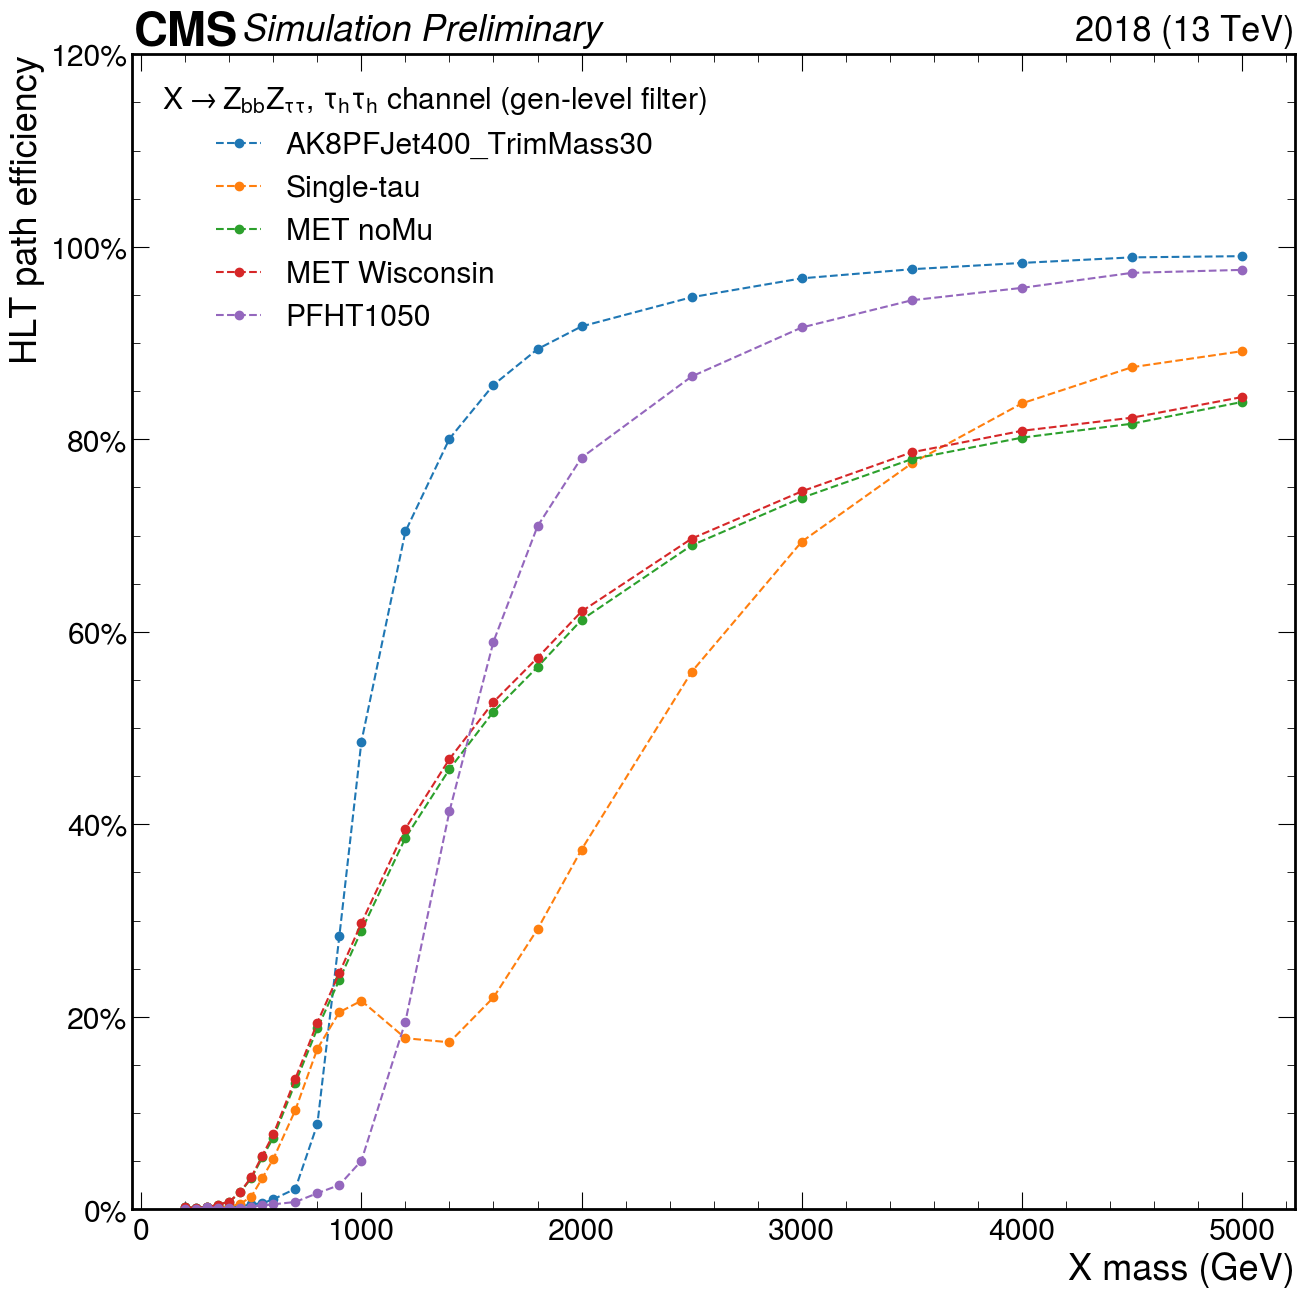

In [60]:

HLT_interesting_paths_subset = [
    ("AK8PFJet400_TrimMass30", "AK8PFJet400_TrimMass30"),
    ("MediumChargedIsoPFTau180HighPtRelaxedIso_Trk50_eta2p1", "Single-tau"),
    ("PFMETNoMu120_PFMHTNoMu120_IDTight", "MET noMu"),
    (("PFMETNoMu120_PFMHTNoMu120_IDTight", "MonoCentralPFJet80_PFMETNoMu120_PFMHTNoMu120_IDTight", "PFMET120_PFMHT120_IDTight"), "MET Wisconsin"),
    ("PFHT1050", "PFHT1050")    
]
effs = defaultdict(dict)
for mass, ar_mass in ars.items():
    tautau_channel_filter = tautau_acceptance(ar_mass)
    cut = tautau_channel_filter

    for hlt_path, label in HLT_interesting_paths_subset:
        
        if isinstance(hlt_path, str):
            hlt_selected = ar_mass["HLT_"+hlt_path]
        else:
            hlt_selected = functools.reduce(operator.or_, [ar_mass["HLT_"+hlt_path_i] for hlt_path_i in hlt_path])

        effs[label][mass] = eff(hlt_selected[tautau_channel_filter], tautau_channel_filter)

    # eff_singlemu_trigger_genmatched[mass] =ak.count_nonzero(singlemu_trigger_matchGen(ar[genMuTau], singlemu_trigger(ar[genMuTau]))) / ak.count_nonzero(genMuTau)

plt.figure(figsize=(15, 15))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("HLT path efficiency")
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{h}\tau_{h}$ channel (gen-level filter)", loc="upper left")
hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

## etau channel

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

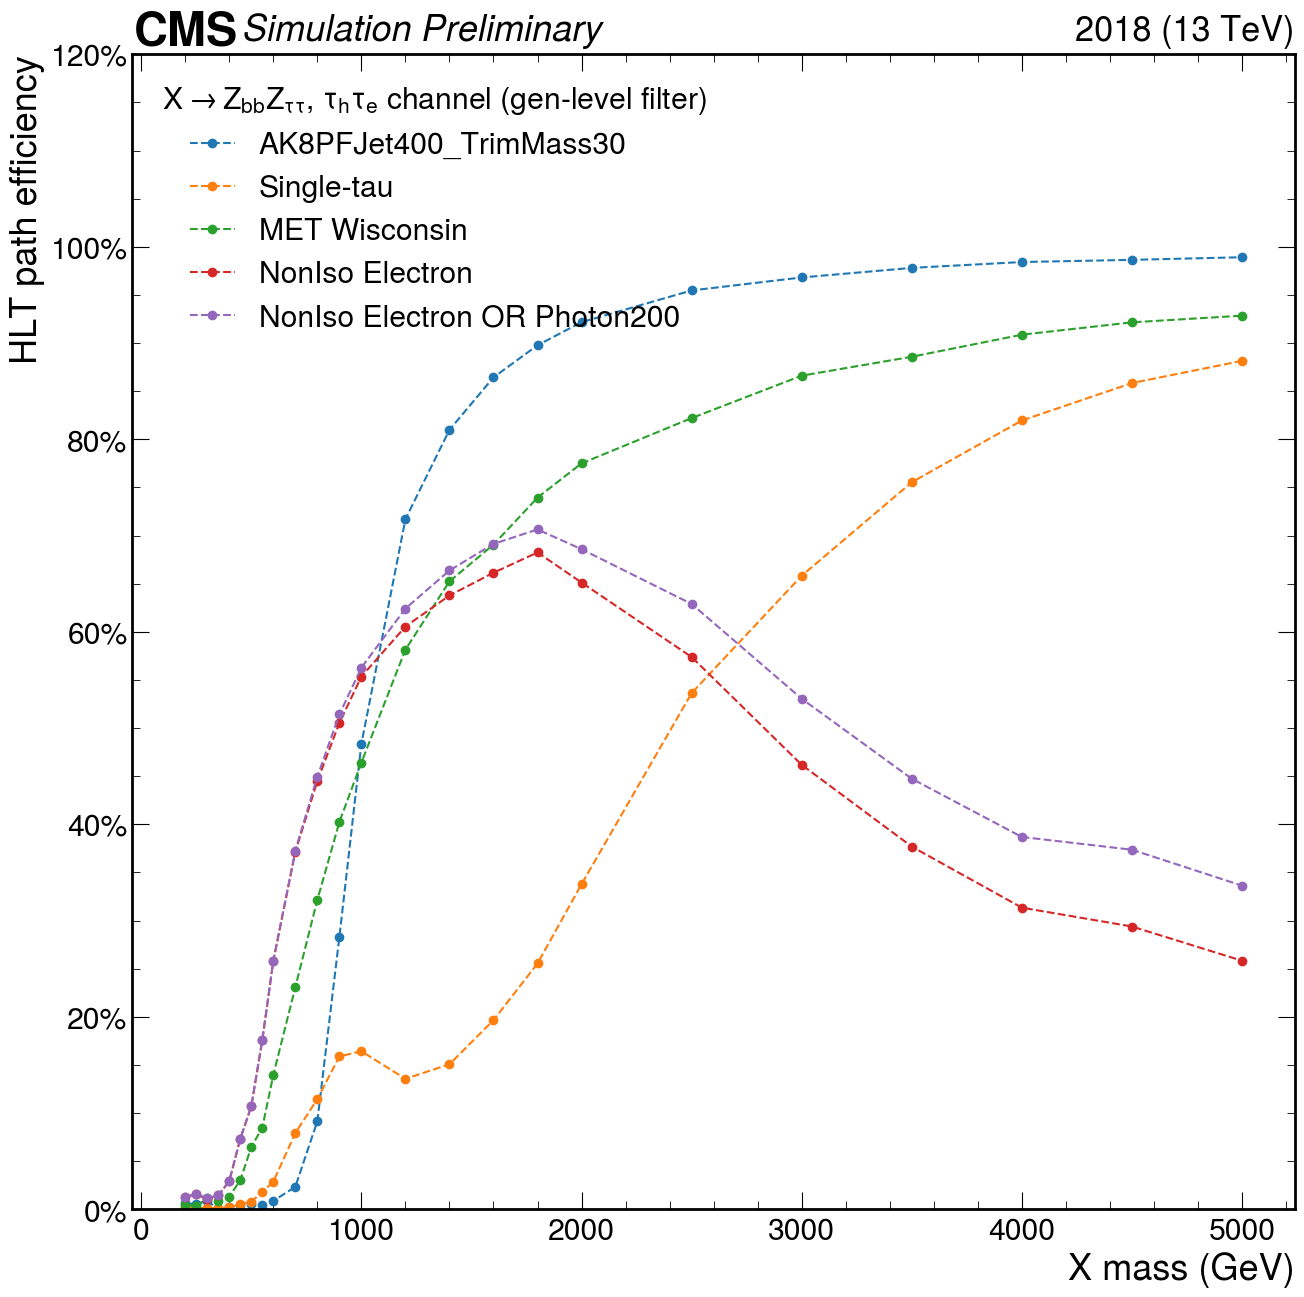

In [57]:
def etau_acceptance(ar):
    return (ar.genPairType == 1) & (ar.genLepton.eta < 2.3) & (ar.genLepton.pt > 20)
HLT_interesting_paths_subset = [
    ("AK8PFJet400_TrimMass30", "AK8PFJet400_TrimMass30"),
    ("MediumChargedIsoPFTau180HighPtRelaxedIso_Trk50_eta2p1", "Single-tau"),
    (("PFMETNoMu120_PFMHTNoMu120_IDTight", "MonoCentralPFJet80_PFMETNoMu120_PFMHTNoMu120_IDTight", "PFMET120_PFMHT120_IDTight"), "MET Wisconsin"),
    (("Ele115_CaloIdVT_GsfTrkIdT", "Ele50_CaloIdVT_GsfTrkIdT_PFJet165"), "NonIso Electron"),
    (("Ele115_CaloIdVT_GsfTrkIdT", "Ele50_CaloIdVT_GsfTrkIdT_PFJet165", "Photon200"), "NonIso Electron OR Photon200"),
]
effs = defaultdict(dict)
for mass, ar_mass in ars.items():
    channel_filter = etau_acceptance(ar_mass) # etau
    cut = channel_filter

    for hlt_path, label in HLT_interesting_paths_subset:
        
        if isinstance(hlt_path, str):
            hlt_selected = ar_mass["HLT_"+hlt_path]
        else:
            hlt_selected = functools.reduce(operator.or_, [ar_mass["HLT_"+hlt_path_i] for hlt_path_i in hlt_path])

        effs[label][mass] = eff(hlt_selected[channel_filter], channel_filter)

    # eff_singlemu_trigger_genmatched[mass] =ak.count_nonzero(singlemu_trigger_matchGen(ar[genMuTau], singlemu_trigger(ar[genMuTau]))) / ak.count_nonzero(genMuTau)

plt.figure(figsize=(15, 15))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("HLT path efficiency")
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{h}\tau_{e}$ channel (gen-level filter)", loc="upper left")
hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

## mutau

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

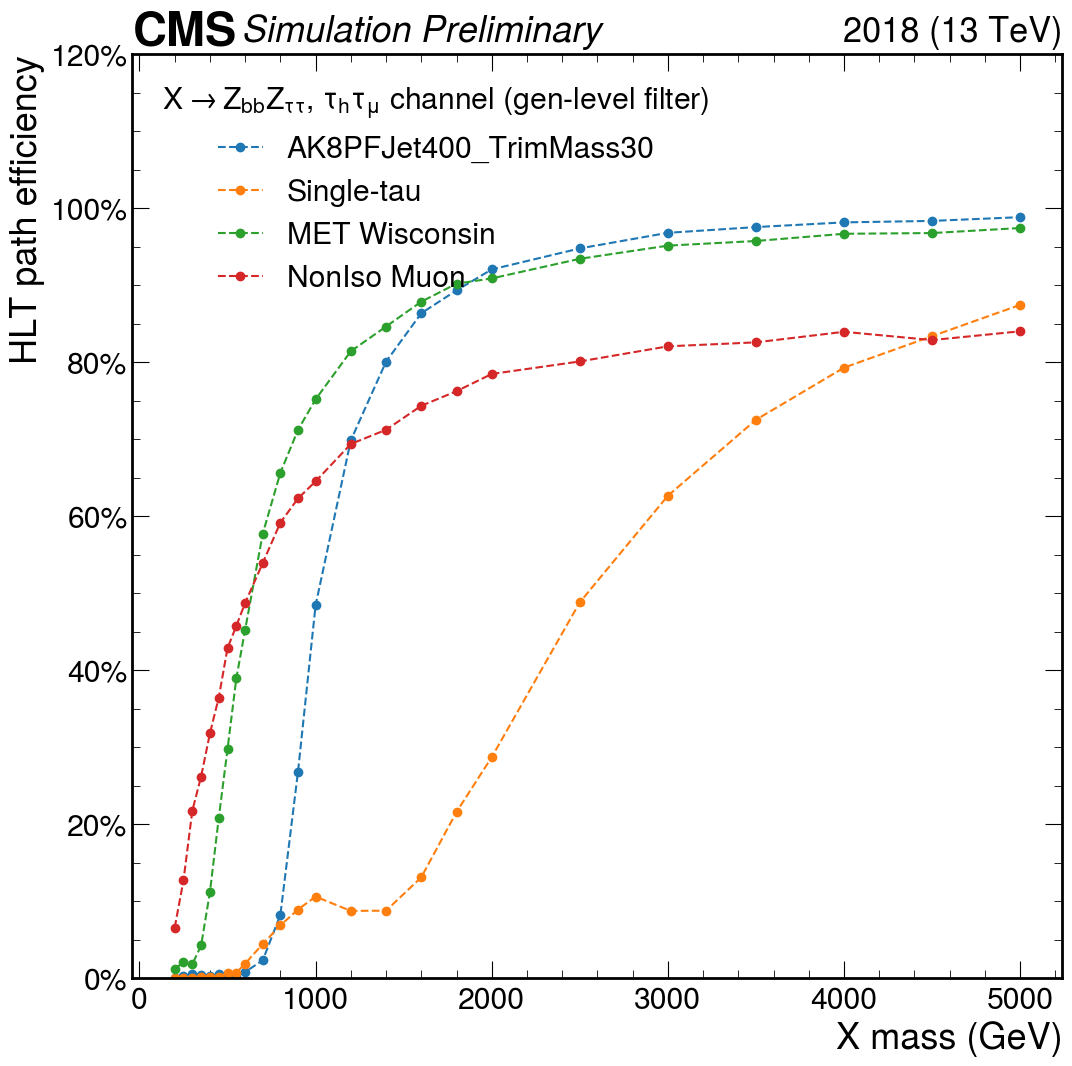

In [56]:
def mutau_acceptance(ar):
    return (ar.genPairType == 0) & (ar.genLepton.eta < 2.4) & (ar.genLepton.pt > 20)
HLT_interesting_paths_subset = [
    ("AK8PFJet400_TrimMass30", "AK8PFJet400_TrimMass30"),
    ("MediumChargedIsoPFTau180HighPtRelaxedIso_Trk50_eta2p1", "Single-tau"),
    (("PFMETNoMu120_PFMHTNoMu120_IDTight", "MonoCentralPFJet80_PFMETNoMu120_PFMHTNoMu120_IDTight", "PFMET120_PFMHT120_IDTight"), "MET Wisconsin"),
    (("Mu50", "OldMu100", "TkMu100"), "NonIso Muon")
]
effs = defaultdict(dict)
for mass, ar_mass in ars.items():
    channel_filter = mutau_acceptance(ar_mass)
    cut = channel_filter

    for hlt_path, label in HLT_interesting_paths_subset:
        
        if isinstance(hlt_path, str):
            hlt_selected = ar_mass["HLT_"+hlt_path]
        else:
            hlt_selected = functools.reduce(operator.or_, [ar_mass["HLT_"+hlt_path_i] for hlt_path_i in hlt_path])

        effs[label][mass] = eff(hlt_selected[channel_filter], channel_filter)

    # eff_singlemu_trigger_genmatched[mass] =ak.count_nonzero(singlemu_trigger_matchGen(ar[genMuTau], singlemu_trigger(ar[genMuTau]))) / ak.count_nonzero(genMuTau)

plt.figure(figsize=(12, 12))
for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("HLT path efficiency")
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{h}\tau_{\mu}$ channel (gen-level filter)", loc="upper left")
hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")